##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [560]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Import TensorFlow and other libraries

In [561]:
import sys
print(sys.version)

3.11.6 (main, Nov  2 2023, 04:39:43) [Clang 14.0.3 (clang-1403.0.22.14.1)]


In [562]:
!{sys.executable} -m pip install pydot-ng
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install IPython


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [1]:
import tensorflow as tf
import scipy.io
import numpy as np

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"GPU found: {gpu}")
else:
    print("No GPU found")

No GPU found


## Load the dataset

Download the CMP Facade Database data (30MB). Additional datasets are available in the same format [here](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/). In Colab you can select other datasets from the drop-down menu. Note that some of the other datasets are significantly larger (`edges2handbags` is 8GB in size). 

In [4]:
dataset_name = "output_images"  #最初の学習はoutput_images1でやったけど、色々統一させるためにoutput_imagesを今は使っている。データは違うけど作り方は一緒
date = '240621'

datasettype = 1 # 0: phantom, 1: real shot
PATH_phantom = pathlib.Path('/Users/shohgookazaki/Documents/GitHub/test-open/Soft X-ray/Machine_Learning/' + dataset_name)
PATH_shot = pathlib.Path('/Users/shohgookazaki/Library/CloudStorage/GoogleDrive-shohgo-okazaki@g.ecc.u-tokyo.ac.jp/My Drive/OnoLab/data')

inputname = 'sxr1'
realname = 'EE1'

mat_file = scipy.io.loadmat('/Users/shohgookazaki/Documents/GitHub/test-open/Soft X-ray/Four-View/parameters5090.mat')
gm2d = mat_file['gm2d1']
gm2d = tf.cast(gm2d, tf.float32)


In [6]:
N_projection = 50
N_grid = 91

Plot a sample of the input and real images:

(50, 50, 1)
(91, 91, 1)
tf.Tensor(24.856567, shape=(), dtype=float32)


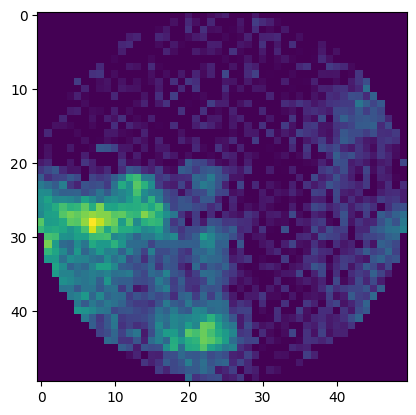

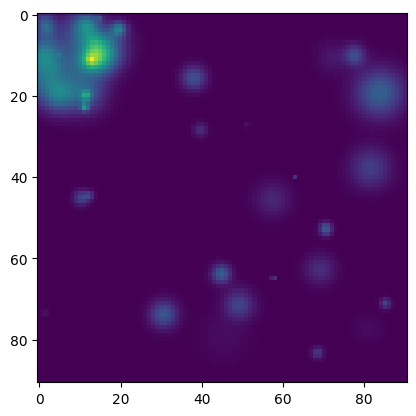

In [7]:
mat_input = scipy.io.loadmat(str(PATH_phantom / 'withnoise_images/image_0001.mat'))
mat_real = scipy.io.loadmat(str(PATH_phantom / 'initial_images/image_0007.mat'))

inp_data = mat_input[inputname]
re_data = mat_real[realname]


inp = tf.convert_to_tensor(inp_data, dtype=tf.float32)
re = tf.convert_to_tensor(re_data, dtype=tf.float32)

inp = tf.expand_dims(inp, -1)
re = tf.expand_dims(re, -1)

print(inp.shape)
print(re.shape)

print(tf.reduce_max(re))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp)
plt.figure()
plt.imshow(re)

As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004), you need to apply random jittering and mirroring to preprocess the training set.

Define several functions that:

1. Resize each `256 x 256` image to a larger height and width—`286 x 286`.
2. Randomly crop it back to `256 x 256`.
3. Randomly flip the image horizontally i.e., left to right (random mirroring).
4. Normalize the images to the `[-1, 1]` range.

In [8]:
# The facade training set consist of 400 images
BUFFER_SIZE = 800
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1

You can inspect some of the preprocessed output:

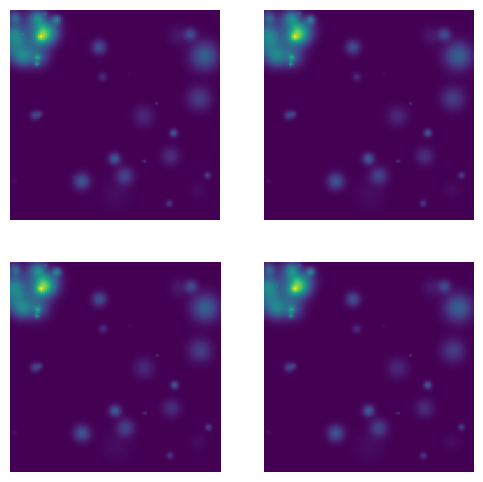

In [9]:
plt.figure(figsize=(6, 6))
for i in range(4):
  plt.subplot(2, 2, i + 1)
  plt.imshow(re / 255.0)
  plt.axis('off')
plt.show()

Having checked that the loading and preprocessing works, let's define a couple of helper functions that load and preprocess the training and test sets:

In [10]:
def get_sorted_file_list(dataset_path, pattern):
    file_list = list(dataset_path.glob(pattern))
    file_list.sort()  # ファイル名順にソート
    return file_list

def load_mat_files(input_path, real_path):
    mat_input = scipy.io.loadmat(input_path.numpy())
    mat_real = scipy.io.loadmat(real_path.numpy())
    return mat_input[inputname], mat_real[realname]  # 必要に応じてキーを変更してください

def wrapper(input_path, real_path):
    input_data, real_data = load_mat_files(input_path, real_path)
    if datasettype == 1:
        real_data = np.flipud(real_data)
    return input_data.astype(np.float32), real_data.astype(np.float32)

def load_data(input_data, real_data):
    input_data, real_data = tf.py_function(
        func=wrapper,
        inp=[input_data, real_data],
        Tout=[tf.float32, tf.float32]
    )
    # Ensure that the output shapes are explicitly set
    #input_data.set_shape([None, None])  # Adjust according to the expected shape of IIwgn
    #real_data.set_shape([None, None])   # Adjust according to the expected shape of EE

    input_data = tf.expand_dims(input_data, -1)
    real_data = tf.expand_dims(real_data, -1)

    return input_data, real_data


## Build an input pipeline with `tf.data`

In [11]:
if datasettype == 0:
    train_input_files = get_sorted_file_list(PATH_phantom / 'withnoise_images', 'image_[0-3][0-9][0-9][0-9].mat')
    train_real_files = get_sorted_file_list(PATH_phantom / 'initial_images', 'image_[0-3][0-9][0-9][0-9].mat')
elif datasettype == 1:
    train_input_files = get_sorted_file_list(PATH_shot / 'SXR_data'/ date, 'shot*/[1-8].mat')
    train_real_files = get_sorted_file_list(PATH_shot / 'result_matrix/LF_LR' / date, 'shot*/[1-8].mat')

train_input_dataset = tf.data.Dataset.from_tensor_slices([str(f) for f in train_input_files])
train_real_dataset = tf.data.Dataset.from_tensor_slices([str(f) for f in train_real_files])

train_dataset = tf.data.Dataset.zip((train_input_dataset, train_real_dataset))

train_dataset = train_dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [12]:
if datasettype == 0:
    test_input_files = get_sorted_file_list(PATH_phantom / 'withnoise_images', 'image_4[0-9][0-9][0-9].mat')
    test_real_files = get_sorted_file_list(PATH_phantom / 'initial_images', 'image_4[0-9][0-9][0-9].mat')
elif datasettype == 1:
    test_input_files = get_sorted_file_list(PATH_shot / 'SXR_data/240622', 'shot*/[1-8].mat')
    test_real_files = get_sorted_file_list(PATH_shot / 'result_matrix/LF_LR/240622', 'shot*/[1-8].mat')

test_input_dataset = tf.data.Dataset.from_tensor_slices([str(f) for f in test_input_files])
test_real_dataset = tf.data.Dataset.from_tensor_slices([str(f) for f in test_real_files])

test_dataset = tf.data.Dataset.zip((test_input_dataset, test_real_dataset))
test_dataset = test_dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Define the downsampler (encoder):

In [13]:
OUTPUT_CHANNELS = 1

In [14]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [15]:
down_model = downsample(3, 4)

down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 25, 25, 3)


Define the upsampler (decoder):

In [16]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [17]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 50, 50, 3)


Define the generator with the downsampler and the upsampler:

In [18]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[N_projection,N_projection,1])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    #downsample(512, 4),  # (batch_size, 2, 2, 512)
    #downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    #upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=1,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)
  
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])
  
  
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Lambda(lambda inputs: tf.image.resize(inputs[0], size=(tf.shape(inputs[1])[1], tf.shape(inputs[1])[2])))([x, skip])
    x = tf.keras.layers.Concatenate()([x, skip])
  
  x = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, size=(N_grid, N_grid)))(x)
  x = last(x)  #tanh使っているから[-1,1]の間しか出力していない
  x = (x + 1) * 25 #だから、ここで[0,50]に変換している
  
  return tf.keras.Model(inputs=inputs, outputs=x)

Visualize the generator model architecture:

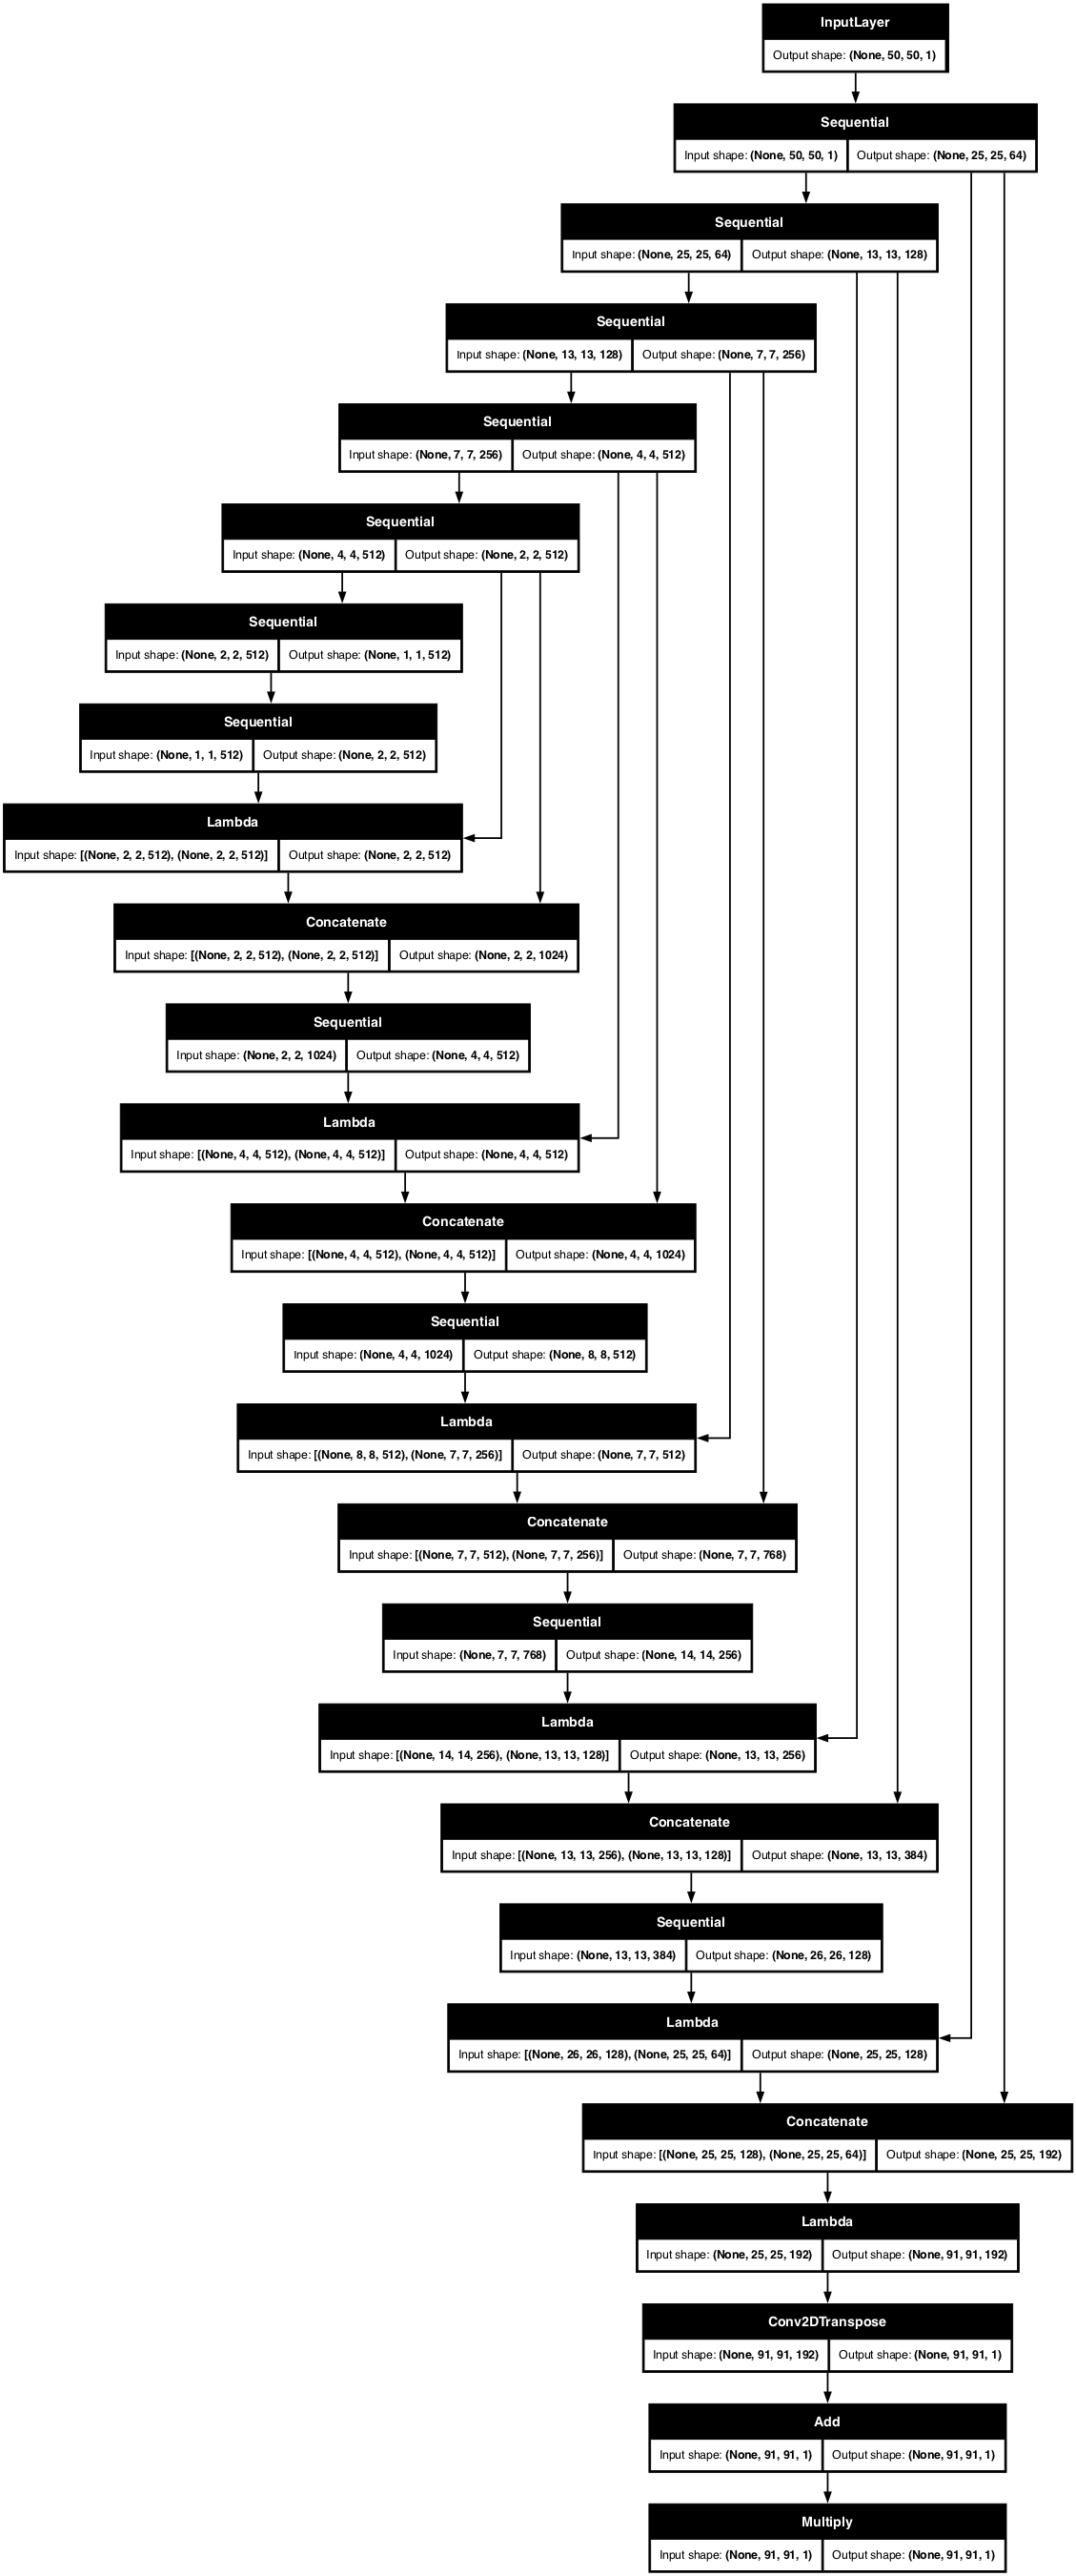

In [19]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Test the generator:

tf.Tensor(49.330647, shape=(), dtype=float32)


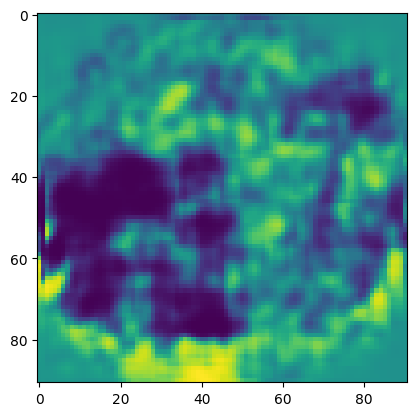

In [20]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])
print(tf.reduce_max(gen_output))

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [21]:
LAMBDA = 100

In [22]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [23]:
a = np.random.rand(3, 3)
print(a)
print(np.where(a < 0.3))

[[0.85935244 0.46689806 0.46372285]
 [0.57185983 0.56659839 0.76948555]
 [0.51963278 0.42258174 0.80395637]]
(array([], dtype=int64), array([], dtype=int64))


In [24]:
def find_circle(L):
    L = int(L)
    R = np.zeros((2*L, 2*L))
    for i in range(2*L):
        for j in range(2*L):
            R[i, j] = np.sqrt((L-0.5 - i)**2 + (j - L+0.5)**2)
            
    k = np.where(R < L)
    return k

1976


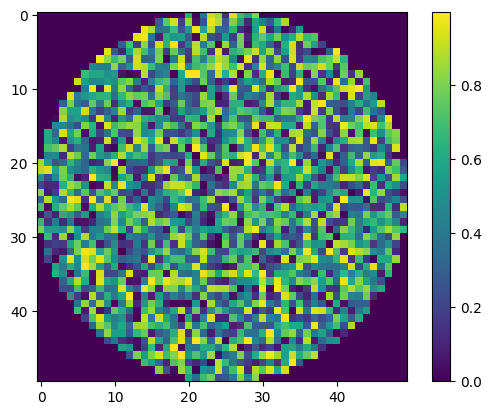

In [25]:
L = 50

k = find_circle(L/2)
Lf = np.random.rand(k[0].shape[0])
R = np.zeros((L,L))
print(k[0].shape[0])

for i in range(k[0].shape[0]):
    R[k[0][i],k[1][i]] = Lf[i]
    
plt.figure()
plt.imshow(R)
plt.colorbar()

In [26]:
tf.config.run_functions_eagerly(True)

In [27]:
def generator_loss(disc_generated_output, gen_output, target, input_image, Lf_cal):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  
  l2_loss = tf.reduce_mean(tf.square(target - gen_output)) 
  
  #最小二乗誤差を以下に計算する結構長いよ----------------------
  #gen_output = tf.image.flip_up_down(gen_output)
  gen_output_t = tf.transpose(gen_output)
  gen_output_vector = tf.reshape(gen_output_t, [-1])
  
  gen_output_vector = tf.expand_dims(gen_output_vector, axis=-1)
  Lf = tf.matmul(gm2d, gen_output_vector)
  
  Lf = Lf.numpy()
  
  k = find_circle(N_projection/2)
  #print(k[0].size)
  #print(gm2d.shape[0])
  
  Lf_cal = np.zeros((N_projection, N_projection))
  for i in range(gm2d.shape[0]):
    Lf_cal[k[0][i],k[1][i]] = Lf[i]
  Lf_calcal = tf.convert_to_tensor(Lf_cal)
  Lf_calcal = tf.cast(Lf_calcal, dtype=tf.float32) 
  
  Lf_calcal = tf.expand_dims(Lf_calcal, axis=-1)
  Lf_calcal = tf.image.flip_up_down(Lf_calcal)
  Lf_calcal = tf.image.rot90(Lf_calcal, k=3)
  # indices = tf.stack([tf.convert_to_tensor(k[0], dtype=tf.int64), tf.convert_to_tensor(k[1], dtype=tf.int64)], axis=1)
  # update = tf.reshape(Lf[:len(k[0])], [-1])
  # Lf_cal = tf.tensor_scatter_nd_update(Lf_cal, indices, update)
  #reshaped_image = tf.reshape(input_image, (50, 50))
  # plt.figure()
  # plt.imshow(input_image[0])
  # plt.colorbar()
  
  # plt.figure()
  # plt.imshow(Lf_calcal)
  # plt.colorbar()  
  projection_loss = tf.reduce_mean(tf.square(Lf_calcal - input_image[0])) #1/M|Hf-g|の最小化
  #ここまで最小二乗誤差の計算--------------------


  #MEM
  epsilon = 1e-10  # Small value to prevent log(0)
  negative_entropy = tf.reduce_mean(tf.math.multiply(gen_output, tf.math.log(gen_output + epsilon)))
  #print(negative_entropy) 

  #Tik
  
  #MFI
  

  #total_gen_loss = gan_loss + (LAMBDA * l1_loss) + projection_loss
  total_gen_loss = gan_loss + 10*l2_loss + projection_loss + negative_entropy

  return total_gen_loss, gan_loss, l1_loss,l2_loss, projection_loss, negative_entropy

The training procedure for the generator is as follows:

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the discriminator

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image _patch_ is real or not real, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.
- The discriminator receives 2 inputs: 
    - The input image and the target image, which it should classify as real.
    - The input image and the generated image (the output of the generator), which it should classify as fake.
    - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

Let's define the discriminator:

In [28]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[N_grid,N_grid,1], name='input_image')
  tar = tf.keras.layers.Input(shape=[N_grid,N_grid,1], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  #down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)
  #down4 = downsample(512, 4)(down3)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Visualize the discriminator model architecture:

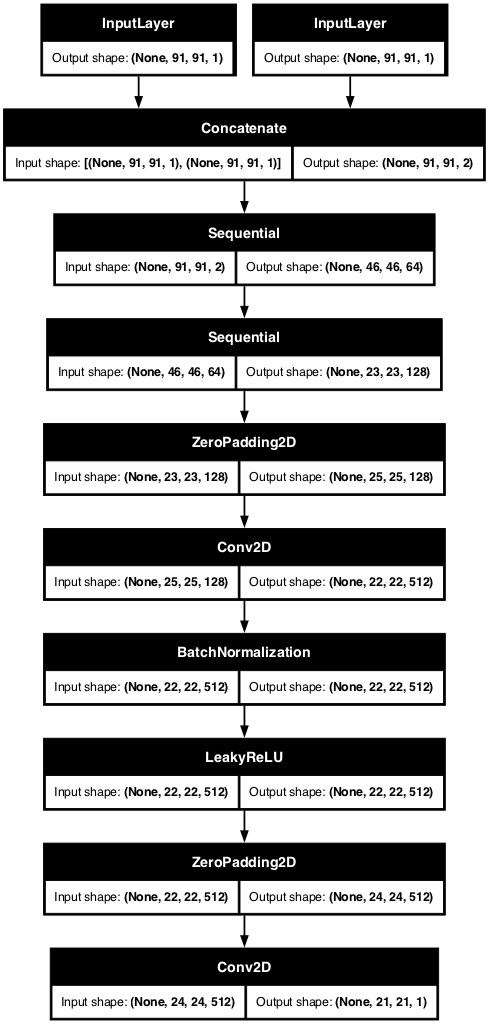

In [29]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Test the discriminator:

Shape of resized input: (91, 91, 1)


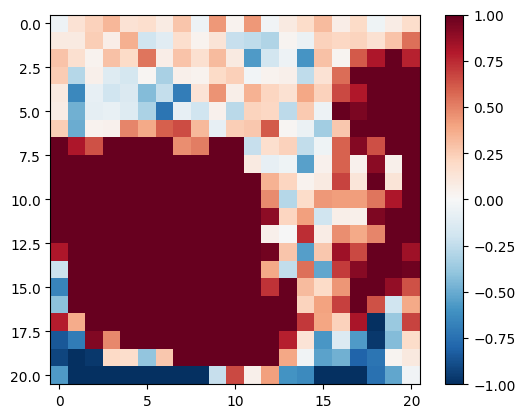

In [30]:
inpt = tf.keras.layers.Lambda(lambda inp: tf.image.resize(inp, size=(N_grid, N_grid)))(inp)
print("Shape of resized input:", inpt.shape)
disc_out = discriminator([inpt[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar()

### Define the discriminator loss

- The `discriminator_loss` function takes 2 inputs: **real images** and **generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the **real images** and an **array of ones(since these are the real images)**.
- `generated_loss` is a sigmoid cross-entropy loss of the **generated images** and an **array of zeros (since these are the fake images)**.
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [31]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer to the [pix2pix paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the optimizers and a checkpoint-saver


In [48]:
generator_optimizer = tf.keras.optimizers.Adam(3e-5, beta_1=0.5) #3e-5
discriminator_optimizer = tf.keras.optimizers.Adam(8e-6, beta_1=0.5) #8e-6

In [33]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images

Write a function to plot some images during training.

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and _voila_!

Note: The `training=True` is intentional here since you want the batch statistics, while running the model on the test dataset. If you use `training=False`, you get the accumulated statistics learned from the training dataset (which you don't want).

In [34]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  # print(max(prediction[0].numpy().flatten()))
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    img = plt.imshow(display_list[i] * 0.5 + 0.5, cmap='viridis')
    #plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
    plt.colorbar(img, shrink=0.2)
  plt.show()

Test the function:

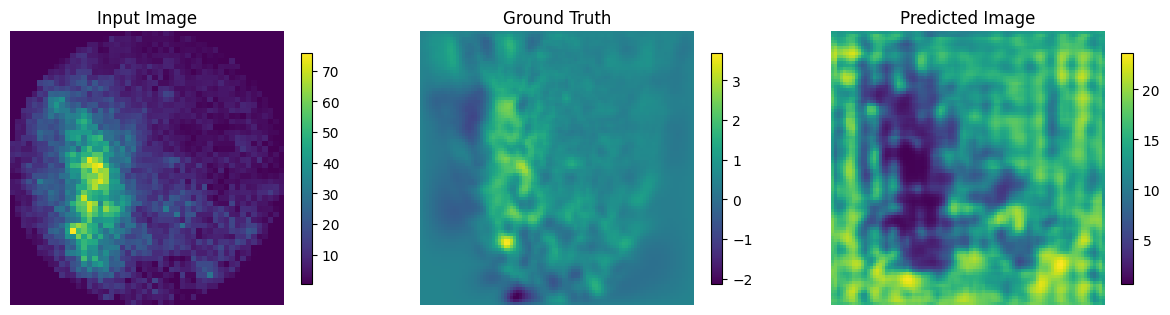

2024-10-03 09:01:58.747335: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
for example_input, example_target in train_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

In [49]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  )

In [40]:
@tf.function
def train_step(input_image, target, step, Lf_cal):
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    
    inpt = tf.keras.layers.Lambda(lambda input_image: tf.image.resize(input_image, size=(N_grid, N_grid)))(input_image)
    disc_real_output = discriminator([inpt, target], training=True)
    
    disc_generated_output = discriminator([inpt, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss, gen_l2_loss, projection_loss, negative_entropy= generator_loss(disc_generated_output, gen_output, target, input_image, Lf_cal)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
  
  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('gen_l2_loss', gen_l2_loss, step=step//1000)
    tf.summary.scalar('projection_loss', projection_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)
    tf.summary.scalar('negative_entropy', negative_entropy, step=step//1000)

The actual training loop. Since this tutorial can run of more than one dataset, and the datasets vary greatly in size the training loop is setup to work in steps instead of epochs.

- Iterates over the number of steps.
- Every 10 steps print a dot (`.`).
- Every 1k steps: clear the display and run `generate_images` to show the progress.
- Every 5k steps: save a checkpoint.

In [41]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")
    
    Lf_cal = tf.Variable(tf.zeros((N_projection, N_projection), dtype=tf.float32))
    train_step(input_image, target, step, Lf_cal)
    #generate_images(generator, input_image, target)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

This training loop saves logs that you can view in TensorBoard to monitor the training progress.

If you work on a local machine, you would launch a separate TensorBoard process. When working in a notebook, launch the viewer before starting the training to monitor with TensorBoard.

Launch the TensorBoard viewer (Sorry, this doesn't
display on tensorflow.org):

In [43]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6010 (pid 53585), started 0:00:05 ago. (Use '!kill 53585' to kill it.)

You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

Finally, run the training loop:

Time taken for 1000 steps: 646.57 sec



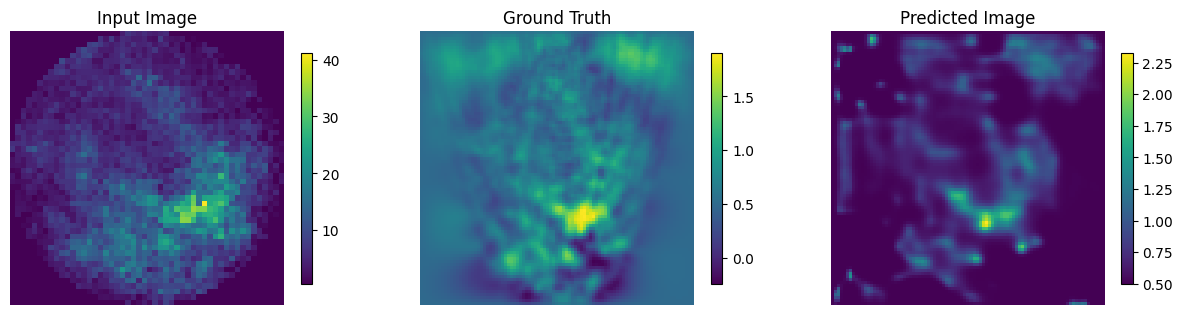

Step: 19k
....................................................................................................

In [56]:
fit(train_dataset, test_dataset, steps=20000)

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

In [50]:
!ls {checkpoint_dir}

checkpoint                  ckpt-24.index
ckpt-24.data-00000-of-00001


In [55]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

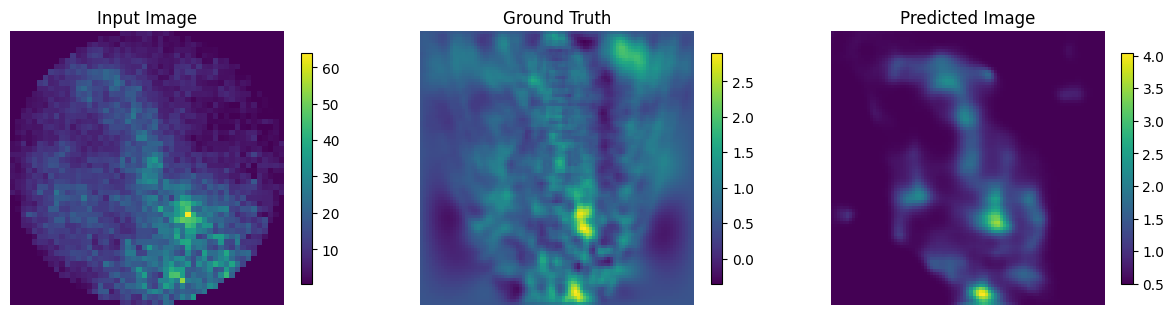

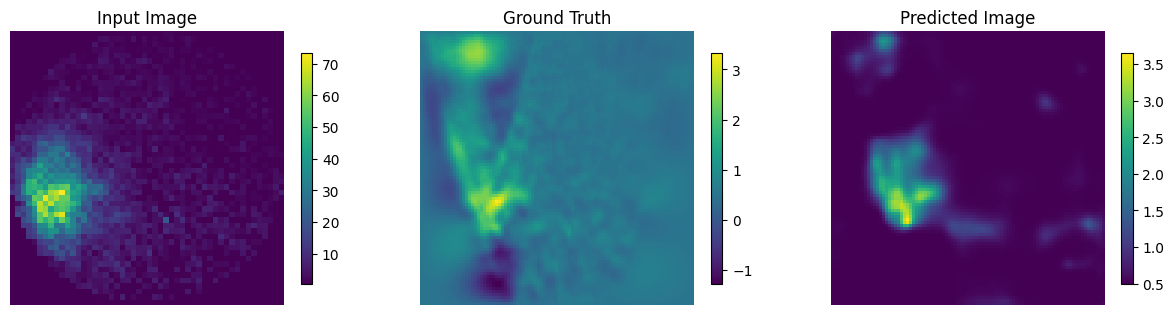

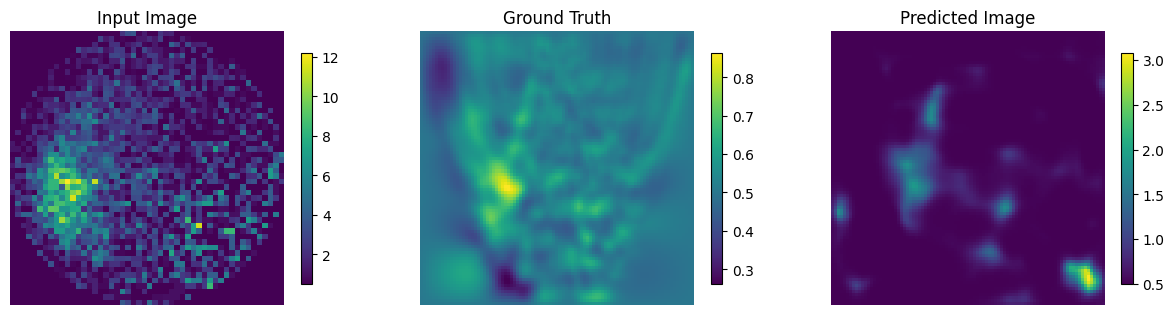

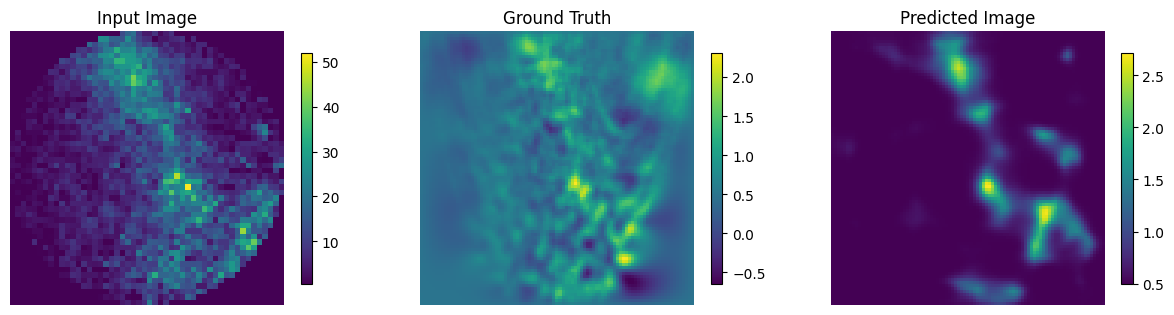

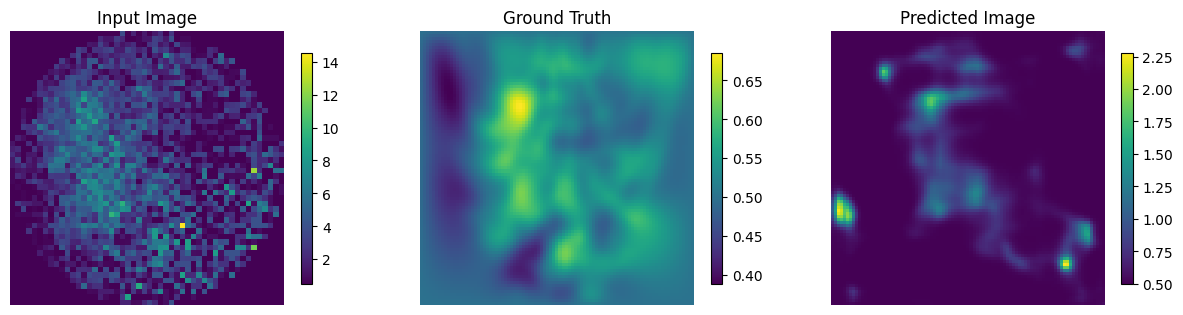

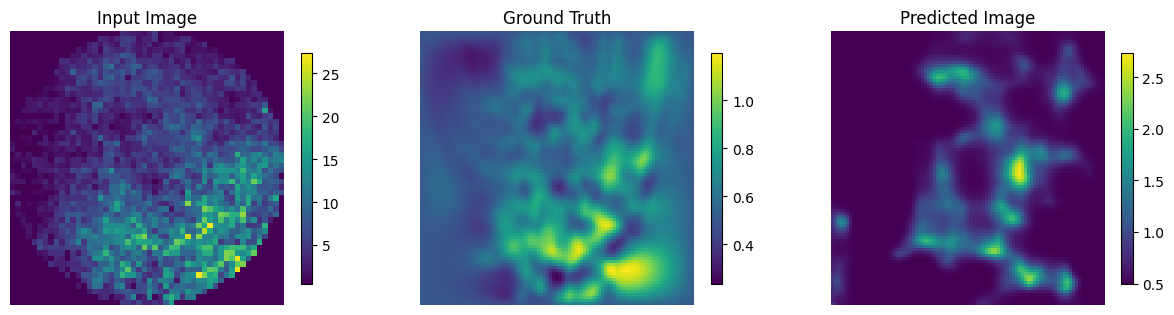

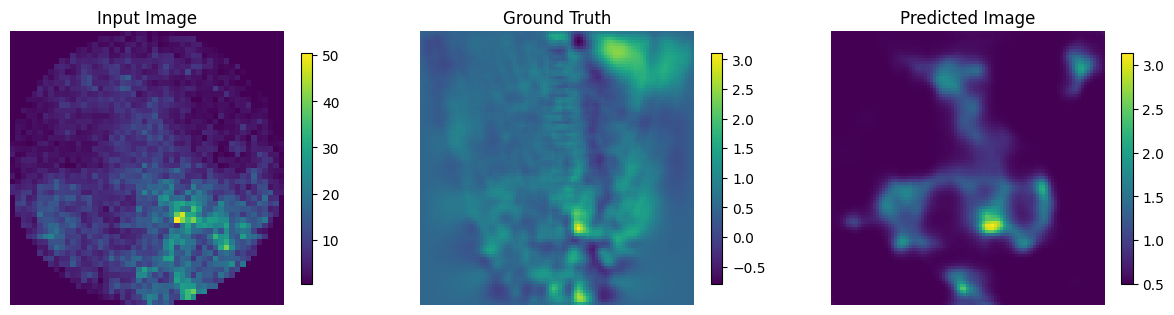

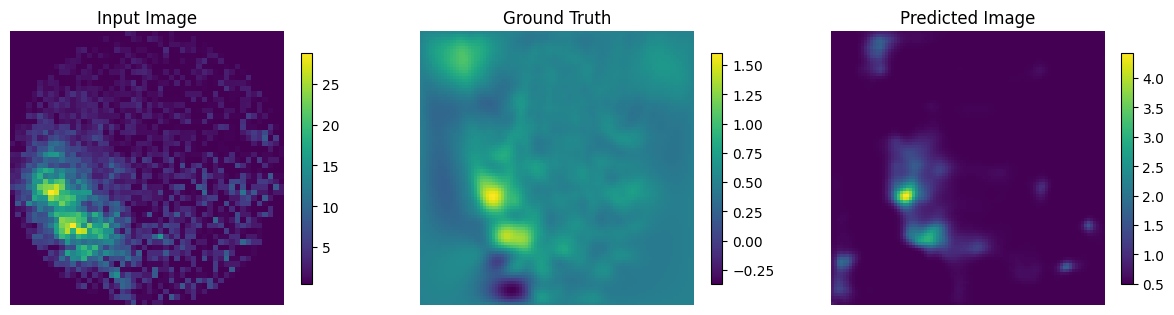

In [46]:
# Run the trained model on a few examples from the test set
for inp, tar in train_dataset.take(8):
  generate_images(generator, inp, tar)